<a href="https://colab.research.google.com/github/Babcock-R17/Image-Processing/blob/main/Independent_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TASKS



1. Fix Layout Structure
  * Inheritance from PIL Image class
2. Create a readme 
  * for the class functions you will be using from the Super Class PIL Image
  * for the functions that will be overrided
  * for the additional functions related to confidence intervals

3. Add Watermark and try to detect the watermark in the image. 
  * Watermark is blended with a transparency mask currently, want to use a custom watermark 
  * Watermark detection 
  * Inpainting, how to remove watermark. 



# Defining Layout Structure

In [ ]:
# Install pillow in order to import PIL 
!pip install pillow
!pip install overloading
!pip install scikit-image

# Reference for the ReadMe file

[Python Documentation on PIL Image](https://pillow.readthedocs.io/en/stable/reference/Image.html)

In [ ]:
#%% [code]
#@title Run Cell and Search for Documentation used {display-mode: "form"}

# This code will be hidden when the notebook is loaded.
import ipywidgets as widgets
import sys
from google.colab import output
from os import listdir
import os
from skimage import io, transform
import matplotlib.pyplot as plt
import numpy as np
from typing import overload
import skimage

DICT_FUNC = {"skimage.transform.resize": skimage.transform.resize.__doc__,
             "io.imshow": io.imshow.__doc__,
             "skimage": skimage.__doc__
             }

def on_change(change):
  global dict_func
  with output.use_tags('code_chunk'):
    sys.stdout.flush();
    if change['type'] == 'change' and change['name'] == 'value':
      output.clear(output_tags='code_chunk')
      sys.stdout.write("Displaying Docs for {} \n {}".format(change['new'][0] , DICT_FUNC[change['new'][0]]))
      sys.stdout.flush();

w = widgets.SelectMultiple(
    options= list(DICT_FUNC.keys()),
    # value=['Image.open'],
    #rows=10,
    description='View Docs',
    disabled=False
)


w.observe(on_change)

display(w)


In [ ]:
# Coded by: Jasen Babcock Python 3.7 in Google Colab 03_04_2022

# Imports
import PIL.Image as Image
from os import listdir
import os
from skimage import io, transform
import PIL
import matplotlib.pyplot as plt
import numpy as np
from typing import overload
import skimage as sk
# playing with Queue
from multiprocessing import SimpleQueue


# Mount Google Colab to load in images. 
from google.colab import drive
drive.mount('/gdrive')

# Get file paths
workspace_path = '/gdrive/MyDrive/Independent_Study/'
workspace_names = listdir(workspace_path)


# Class objects
# Parent Class
class Photo():
  def __init__(self, fp, fname, image):
    self.__fp = fp
    self.__fname = fname
    self.__image = image.astype(np.uint8)
    self.__shape = np.asarray(image).shape
    self.__title = fname

  @property
  def fp(self):
    return self.__fp
  @property
  def fname(self):
    return self.__fname 
  @property
  def image(self):
    return self.__image
  @property
  def shape(self):
    return self.__shape
  @property
  def width(self):
    return self.__shape[0]
  @property
  def hieght(self):
    return self.__shape[1]
  @property
  def channel(self):
    try:
      return self.__shape[2]
    except ValueError as e:
      print(e)
      return None  
  @property
  def title(self):
    return self.__title
  @fp.setter
  def fp(self, fp):
    self.__fp = fp  
  @fname.setter
  def fname(self, fname):
    self.__fname = fname 
  @image.setter
  def image(self, image):
    self.__image = image
  @shape.setter
  def shape(self, shape):
    self.__shape = shape
  @title.setter
  def title(self, title):
    self.__title = title

  # Class Methods
  def describe(self):
    name = self.fname
    shape = self.shape 
    print("Image {} has a shape of {} ".format(name, shape))

  def add_to_book(self, book):
      if book is not None:
        book[self.__fname] = self
      else:
        book[self.__fname] = self

  def is_in_book(self, book):
    return self.__image in book.value
      
  def show(self):
    io.imshow(self.__image)
    io.show()

  @staticmethod
  def save(fp, fname, image_array):
    io.imsave(os.path.join(fp, fname), image_array)
  @staticmethod
  def show_array(image_array):
    io.imshow(image_array)
    io.show()
  @staticmethod
  def show_multiple(book):
    keys = list(book.keys())
    plt.subplot(2*(len(keys)//2), 2*(len(keys)//2), len(keys))
    i = 0
    for key in keys:
      plt.subplot(2*(len(keys)//2), len(keys)-(len(keys)//2),1+i)
      io.imshow(book[key].image)
      i+=1
    io.show()




# Child class
class Image_Processing(Photo):
  def __init__(self, fp , fname):
    img = io.imread(os.path.join(fp, fname))
    super().__init__(fp, fname, img)
  
  # Class Methods
  def remove_color(self, target_color):
    """
    Inputs target color
    Output is np.ndarray of pixel values. 
    if file_path is included the image will be saved. 
    """
    image = self.image
    temp_image = np.where(image == target_color, 0, image)
    self.image = temp_image
  
  def alpha_blend_watermark(self, watermark_array, target_shape, location, alpha):
    def mask(watermark_array, target_shape):
      """
      Input: target_shape is a nparray with desired size
      Input: watermark_array is an ndarray.
      Description: Creates a mask that seperates the color accross a bias of 1/2 pixel,
      and to equal a 1 or 0.      
      Outputs: an numpy ndarray 
      """    
      watermark_array = watermark_array.astype(np.uint8)
      mask = np.full(target_shape, 1.0, dtype=np.uint8)
      watermark_array = transform.resize(watermark_array, target_shape, cval=0)
      mask = np.where(watermark_array >= 0.5, 1.0, 0.0)
      return mask.astype(np.uint8)

    img_with_watermark = self.image.astype(np.uint8)
    mask1 = mask(watermark_array, target_shape)
    n, d, c = target_shape
    x, y = location
    try:
      sub_img = self.image[x:n , y:d,:]
      img_with_watermark[x:n , y:d,:] = np.multiply(sub_img, mask1)
      image_with_watermark = self.image*(1 - alpha) + alpha*img_with_watermark
      return image_with_watermark.astype(np.uint8)
    except ValueError as e:
      # Must resize mask to fit inside of image.
      print(e, "\n Rescaling to 1")
      return self.alpha_blend_watermark(watermark_array, self.shape, location, alpha)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


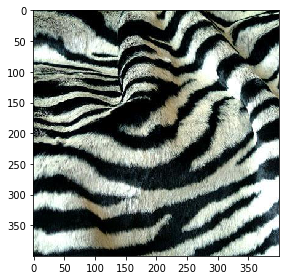

Image striped_0088.jpg has a shape of (400, 400, 3) 


In [ ]:
# Creating a photo and adding to the photobook
# defining my  photobook as book1
book1 = dict() 

# Set file paths
## Image file Path
img_path = os.path.join(workspace_path, "Full_Images/Custom")
image_names = listdir(img_path)

# defining my photo name as test_fname  
test_fname = image_names[0]  # select first image in folder
test_img = Image_Processing(fp=img_path, fname=test_fname)

test_img.add_to_book(book1)
test_img.show()
test_img.describe()

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:163: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  ax.get_figure().tight_layout()


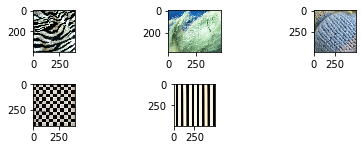

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


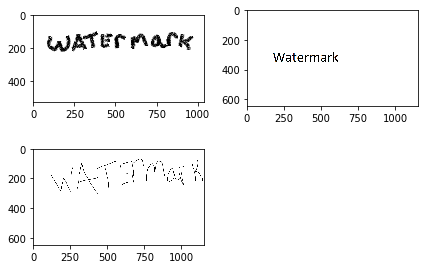

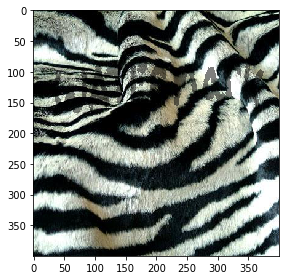

In [ ]:
# Set file paths
## Image file Path
img_path = os.path.join(workspace_path, "Full_Images/Custom")
image_names = listdir(img_path)

# loading photos into a Queue
book = dict()  
for fname in image_names:
  (Image_Processing(fp=img_path, fname=fname)).add_to_book(book)

Photo.show_multiple(book)

test_img = book[list(book.keys())[0] ]


## Watermark file path
water_book = dict() 
water_path = os.path.join(workspace_path, "Watermarks/")

# loading watermarks into a Queue
watermark_names = listdir(water_path)
for water_fname in watermark_names:
  (Image_Processing(fp=water_path, fname=water_fname)).add_to_book(water_book)

Photo.show_multiple(water_book)
water_img = water_book[list(water_book.keys())[0]] 


# set Shape of desired watermark
adjust_shape = lambda h, w, c, size_param: np.array([int(size_param*h), int(size_param*w), c])
h, w, c = test_img.shape
size_param = 1
target_shape = adjust_shape(h, w, c, size_param)

location = [0, 0]
alpha = 0.5
composite_img = test_img.alpha_blend_watermark(water_img.image, target_shape, location, alpha)

Photo.show_array(composite_img)